In [3]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent          # lawson-quant-library/
DATA = ROOT / "src" / "lawson_quant_library" / "data"

vix = pd.read_csv(DATA / "vix_history.csv")
skew = pd.read_csv(DATA / "skew_history.csv")

vix.head()

,DATE\tOPEN\tHIGH\tLOW\tCLOSE
0,01/02/1990\t17.240000\t17.240000\t17.240000\t1...
1,01/03/1990\t18.190000\t18.190000\t18.190000\t1...
2,01/04/1990\t19.220000\t19.220000\t19.220000\t1...
3,01/05/1990\t20.110000\t20.110000\t20.110000\t2...
4,01/08/1990\t20.260000\t20.260000\t20.260000\t2...


In [4]:
print(vix.columns)
vix.head(2)

Index(['DATE\tOPEN\tHIGH\tLOW\tCLOSE'], dtype='object')


,DATE\tOPEN\tHIGH\tLOW\tCLOSE
0,01/02/1990\t17.240000\t17.240000\t17.240000\t1...
1,01/03/1990\t18.190000\t18.190000\t18.190000\t1...


In [13]:
import pandas as pd
from pathlib import Path

VIX_PATH = Path("../src/lawson_quant_library/data/vix_history.csv")

vix = pd.read_csv(VIX_PATH, sep="\t")
vix.columns

Index(['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE'], dtype='object')

In [14]:
vix["DATE"] = pd.to_datetime(vix["DATE"])
vix = vix[["DATE", "CLOSE"]].rename(columns={"CLOSE": "VIX"})
vix.head()

,DATE,VIX
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [9]:
from pathlib import Path
import pandas as pd

SKEW_PATH = Path("../src/lawson_quant_library/data/skew_history.csv")

skew = pd.read_csv(SKEW_PATH, sep="\t")
print(skew.columns)
skew.head()

Index(['DATE', 'SKEW'], dtype='object')


,DATE,SKEW
0,01/02/1990,126.09
1,01/03/1990,123.34
2,01/04/1990,122.62
3,01/05/1990,121.27
4,01/08/1990,124.12


In [10]:
skew["DATE"] = pd.to_datetime(skew["DATE"])
skew = skew[["DATE", "SKEW"]]
skew.head()

,DATE,SKEW
0,1990-01-02,126.09
1,1990-01-03,123.34
2,1990-01-04,122.62
3,1990-01-05,121.27
4,1990-01-08,124.12


In [11]:
df = vix.merge(skew, on="DATE", how="inner")
df["SKEW_PROXY"] = df["SKEW"] - 100.0
df.tail()

,DATE,VIX,SKEW,SKEW_PROXY
9049,2026-01-06,14.75,146.23,46.23
9050,2026-01-07,15.38,143.57,43.57
9051,2026-01-08,15.45,147.08,47.08
9052,2026-01-09,14.49,146.04,46.04
9053,2026-01-12,15.12,149.75,49.75


In [15]:
vix = vix.copy()
vix["DATE"] = pd.to_datetime(vix["DATE"])
vix.head()

,DATE,VIX
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [16]:
import pandas as pd
import numpy as np

from lawson_quant_library.parameter import IRCurve, EQVol
from lawson_quant_library.parameter.curves import DivCurve
from lawson_quant_library.instrument import EQOption

REFERENCE_DATE = "2026-01-06"   # just for curve ref date
SPOT = 100.0

TENORS = {
    "1M": "2026-02-06",
    "3M": "2026-04-06",
    "1Y": "2027-01-06",
}

# strike proxies for “25Δ”
K_ATM = SPOT
K_CALL_25 = SPOT * 1.05
K_PUT_25  = SPOT * 0.95

In [17]:
# You should already have vix and skew dataframes.
# Expect vix: columns ["DATE","VIX"], skew: columns ["DATE","SKEW"]

df = pd.merge(vix[["DATE","VIX"]], skew[["DATE","SKEW"]], on="DATE", how="inner")
df = df.sort_values("DATE").reset_index(drop=True)

# keep last ~1 year for the “past year or so” view (adjust as you like)
df_1y = df[df["DATE"] >= (df["DATE"].max() - pd.Timedelta(days=365))].copy()
df_1y.head()

,DATE,VIX,SKEW
8803,2025-01-13,19.19,170.55
8804,2025-01-14,18.71,167.64
8805,2025-01-15,16.12,163.54
8806,2025-01-16,16.60,167.41
8807,2025-01-17,15.97,165.35


In [18]:
ir_curve = IRCurve.from_deposit_quotes(
    {"1M": 0.0500, "3M": 0.0520, "6M": 0.0530, "1Y": 0.0550},
    reference_date=REFERENCE_DATE,
    name="USD_IR",
)
div_curve = DivCurve(0.0)

vol = EQVol(currency="USD")  # we'll update vol each date

In [19]:
def atm_vol_from_vix(vix_level: float) -> float:
    # VIX is percent (e.g. 20 = 20% vol)
    return float(vix_level) / 100.0

def skew_bump_from_skew(skew_level: float) -> float:
    # SKEW ~ 100 baseline; convert to a small bump factor
    # e.g. 130 -> 0.30 “skew intensity”
    return max(0.0, (float(skew_level) - 100.0) / 100.0)

In [20]:
rows = []

for _, r in df_1y.iterrows():
    dt = r["DATE"]
    atm = atm_vol_from_vix(r["VIX"])
    skew_intensity = skew_bump_from_skew(r["SKEW"])

    # translate skew into call/put vol adjustments (simple, symmetric)
    call25_vol = atm * (1.0 + 0.5 * skew_intensity)
    put25_vol  = atm * (1.0 - 0.5 * skew_intensity)

    for tenor, maturity in TENORS.items():
        # ATM option uses ATM vol
        vol.set_flat_vol(atm, reference_date=REFERENCE_DATE)
        atm_call = EQOption(
            spot=SPOT,
            strike=K_ATM,
            maturity_date=maturity,
            option_type="call",
            ir_curve=ir_curve,
            div_curve=div_curve,
            vol=vol,
            pricing_engine="bs_analytic",
        )
        atm_price = atm_call.price()
        atm_delta = atm_call.delta()
        atm_vega  = atm_call.vega()

        # 25Δ call proxy
        vol.set_flat_vol(call25_vol, reference_date=REFERENCE_DATE)
        call25 = EQOption(
            spot=SPOT,
            strike=K_CALL_25,
            maturity_date=maturity,
            option_type="call",
            ir_curve=ir_curve,
            div_curve=div_curve,
            vol=vol,
            pricing_engine="bs_analytic",
        )
        call25_price = call25.price()

        # 25Δ put proxy
        vol.set_flat_vol(put25_vol, reference_date=REFERENCE_DATE)
        put25 = EQOption(
            spot=SPOT,
            strike=K_PUT_25,
            maturity_date=maturity,
            option_type="put",
            ir_curve=ir_curve,
            div_curve=div_curve,
            vol=vol,
            pricing_engine="bs_analytic",
        )
        put25_price = put25.price()

        rr_price = call25_price - put25_price

        rows.append({
            "DATE": dt,
            "TENOR": tenor,
            "VIX": r["VIX"],
            "SKEW": r["SKEW"],
            "ATM_VOL": atm,
            "ATM_PRICE": atm_price,
            "ATM_DELTA": atm_delta,
            "ATM_VEGA": atm_vega,
            "RR_PRICE": rr_price,
        })

out = pd.DataFrame(rows)
out.head()

,DATE,TENOR,VIX,SKEW,ATM_VOL,ATM_PRICE,ATM_DELTA,ATM_VEGA,RR_PRICE
0,2025-01-13,1M,19.19,170.55,0.1919,2.443896,0.541308,11.563998,1.232576
1,2025-01-13,3M,19.19,170.55,0.1919,4.441907,0.571890,19.487503,3.137794
2,2025-01-13,1Y,19.19,170.55,0.1919,10.336839,0.646101,37.188091,9.231092
3,2025-01-14,1M,18.71,167.64,0.1871,2.388393,0.541802,11.562497,1.142445
4,2025-01-14,3M,18.71,167.64,0.1871,4.348386,0.572766,19.479567,2.963957


In [21]:
# show last few values per tenor
out.groupby("TENOR").tail(3)

,DATE,TENOR,VIX,SKEW,ATM_VOL,ATM_PRICE,ATM_DELTA,ATM_VEGA,RR_PRICE
744,2026-01-08,1M,15.45,147.08,0.1545,2.011673,0.546420,11.547586,0.606956
745,2026-01-08,3M,15.45,147.08,0.1545,3.714495,0.580912,19.401167,1.891629
746,2026-01-08,1Y,15.45,147.08,0.1545,8.957856,0.664079,36.470536,6.671858
747,2026-01-09,1M,14.49,146.04,0.1449,1.900847,0.548335,11.540940,0.519420
748,2026-01-09,3M,14.49,146.04,0.1449,3.528405,0.584272,19.366382,1.723680
749,2026-01-09,1Y,14.49,146.04,0.1449,8.609063,0.670671,36.185273,6.336250
750,2026-01-12,1M,15.12,149.75,0.1512,1.973569,0.547043,11.545453,0.602549
751,2026-01-12,3M,15.12,149.75,0.1512,3.650489,0.582006,19.389997,1.899976
752,2026-01-12,1Y,15.12,149.75,0.1512,8.837653,0.666231,36.378713,6.704329


In [23]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 13.8 MB/s  0:00:00 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 13.1 MB/s  0:00:00 eta 0:00:01
Using cached pyparsing-3.3.1-py3-none-any.whl (121 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


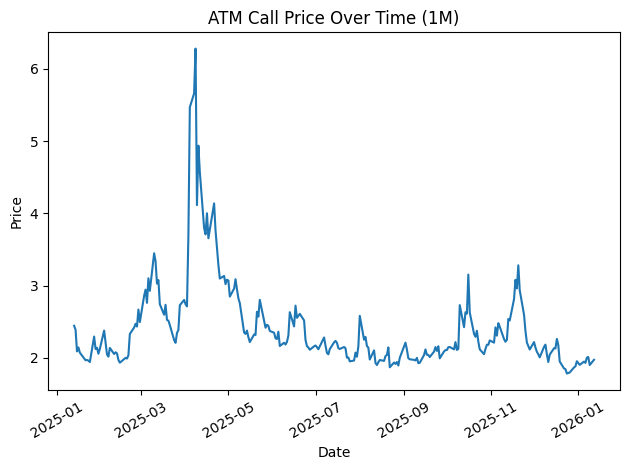

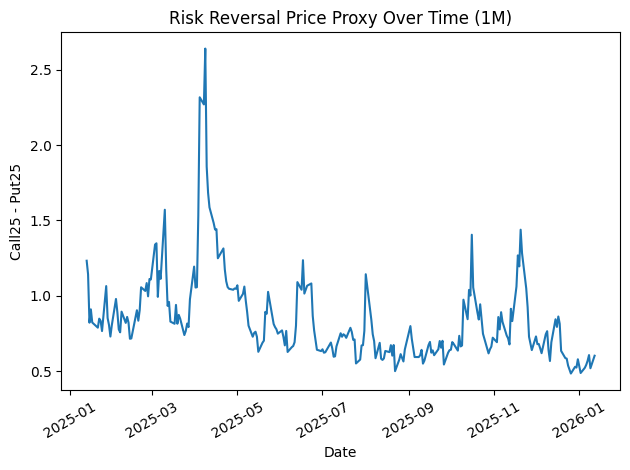

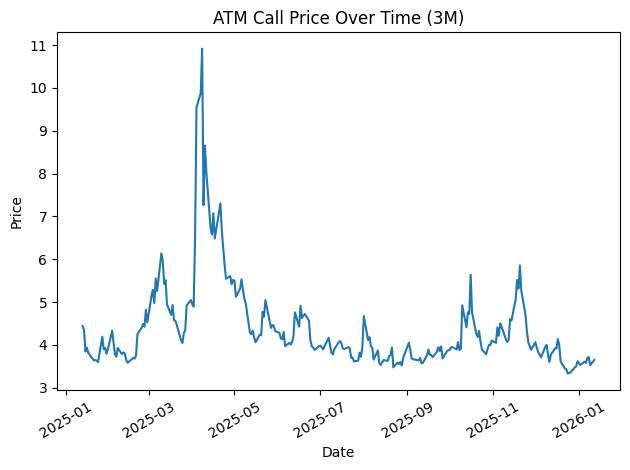

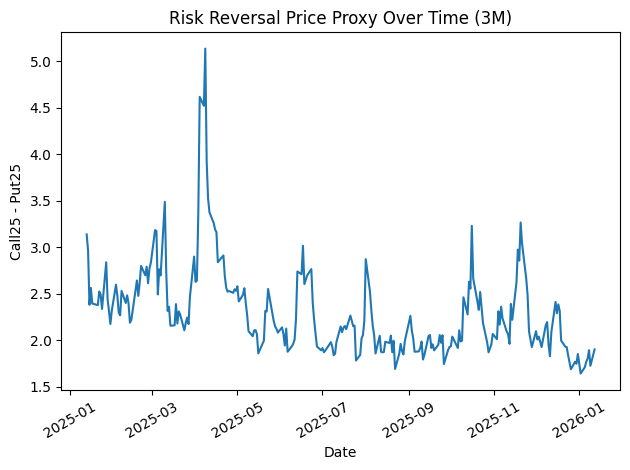

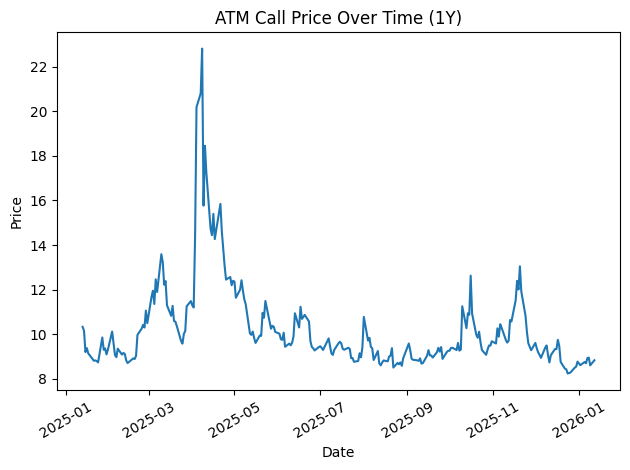

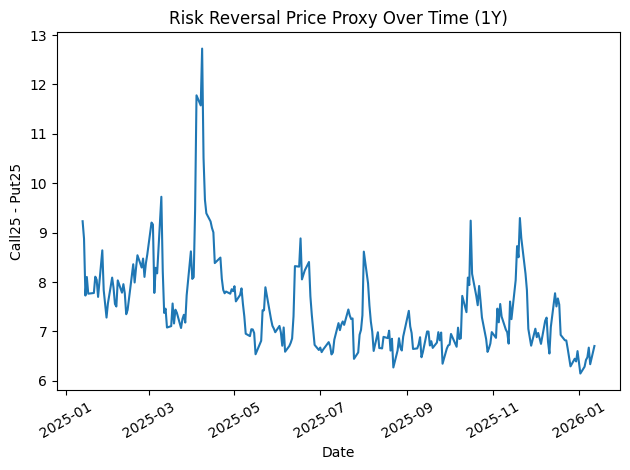

In [24]:
import matplotlib.pyplot as plt

for tenor in TENORS:
    tmp = out[out["TENOR"] == tenor]

    plt.figure()
    plt.plot(tmp["DATE"], tmp["ATM_PRICE"])
    plt.title(f"ATM Call Price Over Time ({tenor})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(tmp["DATE"], tmp["RR_PRICE"])
    plt.title(f"Risk Reversal Price Proxy Over Time ({tenor})")
    plt.xlabel("Date")
    plt.ylabel("Call25 - Put25")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

In [25]:
df["skew_chg"] = df["SKEW"].diff()
df["vix_chg"]  = df["VIX"].diff()

df.sort_values("skew_chg", ascending=False).head(10)[["DATE","SKEW","skew_chg","VIX","vix_chg"]]

,DATE,SKEW,skew_chg,VIX,vix_chg
137,1990-07-18,133.75,26.10,18.90,2.24
6460,2015-09-14,142.93,24.75,24.25,1.05
4071,2006-03-16,142.02,22.90,11.98,0.63
7067,2018-02-12,148.02,19.51,25.61,-3.45
8803,2025-01-13,170.55,19.10,19.19,-0.35
8575,2024-02-13,170.52,17.72,15.85,1.92
5581,2012-03-15,136.51,17.69,15.42,0.11
140,1990-07-23,127.13,17.42,23.68,8.05
6659,2016-06-28,153.66,17.23,18.75,-5.10
6475,2015-10-05,132.83,17.08,19.54,-1.40
